In [ ]:
%%capture
!pip install gcpds-cv-pykit
!pip install fvcore

In [ ]:
import wandb
import torch
import numpy as np
from torch.amp import autocast
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from fvcore.nn import FlopCountAnalysis, parameter_count_table
from gcpds_cv_pykit.segmentation.datasets import SeedGermination
from gcpds_cv_pykit.segmentation.baseline import PerformanceModels
from gcpds_cv_pykit.segmentation.visuals import random_sample_visualization
from gcpds_cv_pykit.segmentation.baseline.dataloaders import Segmentation_DataLoader
from gcpds_cv_pykit.segmentation.baseline.models import UNet, ResUNet, DeepLabV3Plus

In [ ]:
# Set a seed
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
SeedGermination('lucasiturriago/seeds/versions/1')

100%|██████████| 0.98G/0.98G [00:46<00:00, 22.3MB/s]

Extracting files...


Path to downloaded dataset files: /root/.cache/kagglehub/datasets/lucasiturriago/seeds/versions/1
Dataset copied to: /content/datasets/seeds
Original folder '/root/.cache/kagglehub/datasets/lucasiturriago/seeds/versions/1' deleted.


'/content/datasets/seeds'

In [ ]:
config = {"Dir of dataset": "./datasets/seeds", "Batch size": 36, "Image size": (256,256), "Input size": (3,256,256),
          "Number of classes": 3, "Single class train": None, "Single class test": None, "Single class valid": None, "Images folder": "images",
          "Data augmentation": False, "Device": "cuda:0", "AMixPre": True, "Pretrained": True, "Activation function": "sigmoid",
          "Save results": True, "Wandb monitoring": ["YOUR_WANB_API"],}

In [ ]:
train_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Train", config["Single class train"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/seeds/Train/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 2458


Organizing masks: 100%|██████████| 2458/2458 [00:00<00:00, 52202.88it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
valid_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Valid", config["Single class valid"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/seeds/Valid/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 231


Organizing masks: 100%|██████████| 231/231 [00:00<00:00, 35331.08it/s]


In [ ]:
test_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Test", config["Single class test"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/seeds/Test/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 118


Organizing masks: 100%|██████████| 118/118 [00:00<00:00, 50928.98it/s]


Images: torch.Size([36, 3, 256, 256]), Masks: torch.Size([36, 3, 256, 256])


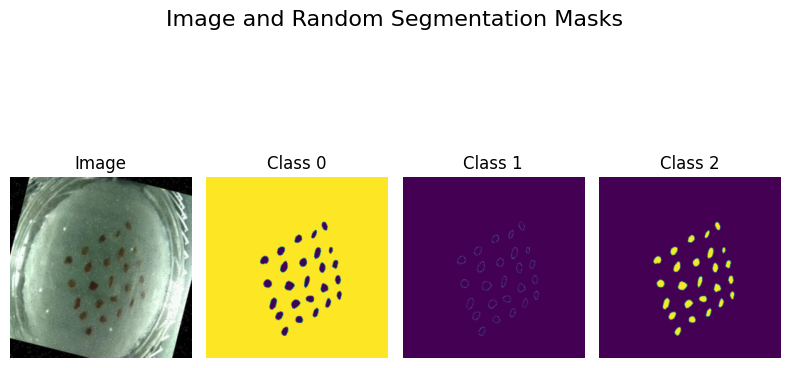

In [ ]:
random_sample_visualization(dataset=train_dataset, num_classes=config["Number of classes"],
                            single_class=config['Single class train'],type='baseline')

In [ ]:
wandb.login(key=config["Wandb monitoring"][0])
run = wandb.init()

# UNet - ResNet34 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v147', type='model')
artifact_dir = artifact.download()

# UNet - MobileNetV3 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v157', type='model')
artifact_dir = artifact.download()

# ResUNet - ResNet34 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v150', type='model')
artifact_dir = artifact.download()

# ResUNet - MobileNetV3 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v160', type='model')
artifact_dir = artifact.download()

# DeepLabV3+ - ResNet34 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v165', type='model')
artifact_dir = artifact.download()

# DeepLabV3+ - MobileNetV3 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v169', type='model')
artifact_dir = artifact.download()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: liturriago (gcpds) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact 'best_model:v147', 93.60MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:09.1 (10.3MB/s)
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact 'best_model:v150', 96.01MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:07.9 (12.2MB/s)
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact 'best_model:v165', 97.71MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:07.9 (12.3MB/s)
wandb:   1 of 1 files downloaded.  


In [ ]:
input_tensor = torch.rand(1, 3, 256, 256).to(torch.device(config.get('Device', 'cpu')))
models_flops = []

In [ ]:
UNet_flops = []

# UNet - ResNet34
UNet_ResNet34_model = UNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="resnet34")
state_dict = torch.load('/content/artifacts/best_model:v147/best_model.pt', weights_only=True)
UNet_ResNet34_model.load_state_dict(state_dict)
UNet_ResNet34_model.to(torch.device(config.get('Device', 'cpu')))
UNet_ResNet34_model.eval()
flops = FlopCountAnalysis(UNet_ResNet34_model, input_tensor)
UNet_flops.append(flops.total())

# UNet - MobileNetV3
UNet_MobileNetV3_model = UNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="mobilenetv3")
state_dict = torch.load('/content/artifacts/best_model:v157/best_model.pt', weights_only=True)
UNet_MobileNetV3_model.load_state_dict(state_dict)
UNet_MobileNetV3_model.to(torch.device(config.get('Device', 'cpu')))
UNet_MobileNetV3_model.eval()
flops = FlopCountAnalysis(UNet_MobileNetV3_model, input_tensor)
UNet_flops.append(flops.total())

models_flops.append(UNet_flops)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:01<00:00, 75.3MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 200MB/s]


In [ ]:
ResUNet_flops = []

# ResUNet - ResNet34
ResUNet_ResNet34_model = ResUNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="resnet34")
state_dict = torch.load('/content/artifacts/best_model:v150/best_model.pt', weights_only=True)
ResUNet_ResNet34_model.load_state_dict(state_dict)
ResUNet_ResNet34_model.to(torch.device(config.get('Device', 'cpu')))
ResUNet_ResNet34_model.eval()
flops = FlopCountAnalysis(ResUNet_ResNet34_model, input_tensor)
ResUNet_flops.append(flops.total())


# ResUNet - MobileNetV3
ResUNet_MobileNetV3_model = ResUNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="mobilenetv3")
state_dict = torch.load('/content/artifacts/best_model:v160/best_model.pt', weights_only=True)
ResUNet_MobileNetV3_model.load_state_dict(state_dict)
ResUNet_MobileNetV3_model.to(torch.device(config.get('Device', 'cpu')))
ResUNet_MobileNetV3_model.eval()
flops = FlopCountAnalysis(ResUNet_MobileNetV3_model, input_tensor)
ResUNet_flops.append(flops.total())

models_flops.append(ResUNet_flops)

In [ ]:
DeepLabV3Plus_flops = []

# DeepLabV3+ - ResNet34
DeepLabV3Plus_ResNet34_model = DeepLabV3Plus(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="resnet34")
state_dict = torch.load('/content/artifacts/best_model:v165/best_model.pt', weights_only=True)
DeepLabV3Plus_ResNet34_model.load_state_dict(state_dict)
DeepLabV3Plus_ResNet34_model.to(torch.device(config.get('Device', 'cpu')))
DeepLabV3Plus_ResNet34_model.eval()
flops = FlopCountAnalysis(DeepLabV3Plus_ResNet34_model, input_tensor)
DeepLabV3Plus_flops.append(flops.total())

# DeepLabV3+ - MobileNetV3
DeepLabV3Plus_MobileNetV3_model = DeepLabV3Plus(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="mobilenetv3")
state_dict = torch.load('/content/artifacts/best_model:v169/best_model.pt', weights_only=True)
DeepLabV3Plus_MobileNetV3_model.load_state_dict(state_dict)
DeepLabV3Plus_MobileNetV3_model.to(torch.device(config.get('Device', 'cpu')))
DeepLabV3Plus_MobileNetV3_model.eval()
flops = FlopCountAnalysis(DeepLabV3Plus_MobileNetV3_model, input_tensor)
DeepLabV3Plus_flops.append(flops.total())

models_flops.append(DeepLabV3Plus_flops)

In [ ]:
images, masks = next(iter(test_dataset))

images = images.to(torch.device(config.get('Device', 'cpu')))
masks = masks.to(torch.device(config.get('Device', 'cpu')))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
with torch.no_grad():
  if config.get("AMixPre", False):
      with autocast(torch.device(config.get('Device', 'cpu')).type):
          UNet_ResNet34_pred = UNet_ResNet34_model(images)
          UNet_MobileNetV3_pred = UNet_MobileNetV3_model(images)
          ResUNet_ResNet34_pred = ResUNet_ResNet34_model(images)
          ResUNet_MobileNetV3_pred = ResUNet_MobileNetV3_model(images)
          DeepLabV3Plus_ResNet34_pred = DeepLabV3Plus_ResNet34_model(images)
          DeepLabV3Plus_MobileNetV3_pred = DeepLabV3Plus_MobileNetV3_model(images)
  else:
      UNet_ResNet34_pred = UNet_ResNet34_model(images)
      UNet_MobileNetV3_pred = UNet_MobileNetV3_model(images)
      ResUNet_ResNet34_pred = ResUNet_ResNet34_model(images)
      ResUNet_MobileNetV3_pred = ResUNet_MobileNetV3_model(images)
      DeepLabV3Plus_ResNet34_pred = DeepLabV3Plus_ResNet34_model(images)
      DeepLabV3Plus_MobileNetV3_pred = DeepLabV3Plus_MobileNetV3_model(images)

In [ ]:
sample = 7
mask_tresh = np.where(masks[sample].cpu().numpy()>0.5,1,0)
mask = np.argmax(mask_tresh, axis=0)

UNet_ResNet34_tresh = np.where(UNet_ResNet34_pred[sample].cpu().numpy()>0.5,1,0)
UNet_ResNet34_pred = np.argmax(UNet_ResNet34_tresh, axis=0)
UNet_ResNet34_accuracy = np.sum(np.where((UNet_ResNet34_tresh[1:,:,:])!=(mask_tresh[1:,:,:]),2,UNet_ResNet34_tresh[1:,:,:]),axis=0)

UNet_MobileNetV3_tresh = np.where(UNet_MobileNetV3_pred[sample].cpu().numpy()>0.5,1,0)
UNet_MobileNetV3_pred = np.argmax(UNet_MobileNetV3_tresh, axis=0)
UNet_MobileNetV3_accuracy = np.sum(np.where((UNet_MobileNetV3_tresh[1:,:,:])!=(mask_tresh[1:,:,:]),2,UNet_MobileNetV3_tresh[1:,:,:]),axis=0)

ResUNet_ResNet34_tresh = np.where(ResUNet_ResNet34_pred[sample].cpu().numpy()>0.5,1,0)
ResUNet_ResNet34_pred = np.argmax(ResUNet_ResNet34_tresh, axis=0)
ResUNet_ResNet34_accuracy = np.sum(np.where((ResUNet_ResNet34_tresh[1:,:,:])!=(mask_tresh[1:,:,:]),2,ResUNet_ResNet34_tresh[1:,:,:]),axis=0)

ResUNet_MobileNetV3_tresh = np.where(ResUNet_MobileNetV3_pred[sample].cpu().numpy()>0.5,1,0)
ResUNet_MobileNetV3_pred = np.argmax(ResUNet_MobileNetV3_tresh, axis=0)
ResUNet_MobileNetV3_accuracy = np.sum(np.where((ResUNet_MobileNetV3_tresh[1:,:,:])!=(mask_tresh[1:,:,:]),2,ResUNet_MobileNetV3_tresh[1:,:,:]),axis=0)

DeepLabV3Plus_ResNet34_tresh = np.where(DeepLabV3Plus_ResNet34_pred[sample].cpu().numpy()>0.5,1,0)
DeepLabV3Plus_ResNet34_pred = np.argmax(DeepLabV3Plus_ResNet34_tresh, axis=0)
DeepLabV3Plus_ResNet34_accuracy = np.sum(np.where((DeepLabV3Plus_ResNet34_tresh[1:,:,:])!=(mask_tresh[1:,:,:]),2,DeepLabV3Plus_ResNet34_tresh[1:,:,:]),axis=0)

DeepLabV3Plus_MobileNetV3_tresh = np.where(DeepLabV3Plus_MobileNetV3_pred[sample].cpu().numpy()>0.5,1,0)
DeepLabV3Plus_MobileNetV3_pred = np.argmax(DeepLabV3Plus_MobileNetV3_tresh, axis=0)
DeepLabV3Plus_MobileNetV3_accuracy = np.sum(np.where((DeepLabV3Plus_MobileNetV3_tresh[1:,:,:])!=(mask_tresh[1:,:,:]),2,DeepLabV3Plus_MobileNetV3_tresh[1:,:,:]),axis=0)

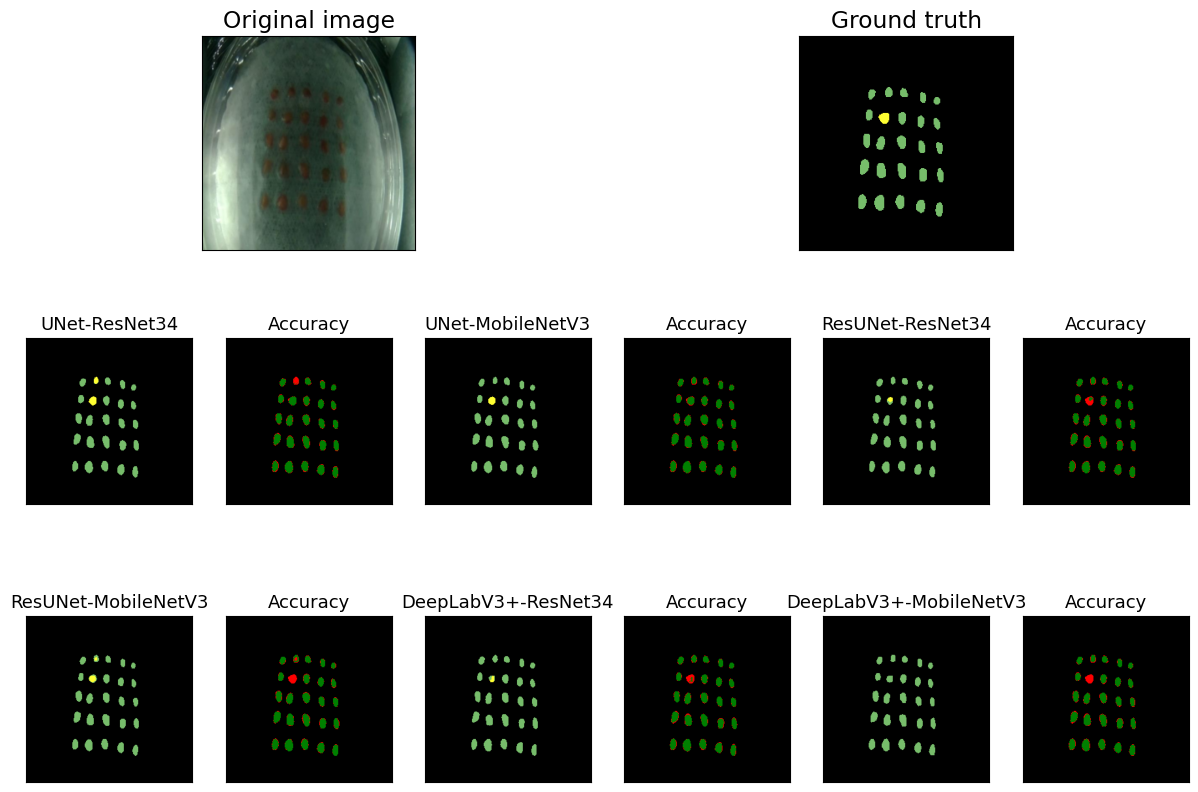

In [ ]:
# ----------  colormap ----------
colors = ['black', 'green', 'red']
cmap_1 = ListedColormap(colors)

colors = ['black', '#FFFF32', '#77BD6B']
cmap_2 = ListedColormap(colors)

plt.rcParams.update({'font.size': 14})

# ----------  Figure with GridSpec ----------
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(3, 6, figure=fig, hspace=0.3, wspace=0.2)

# =========================================================
# Row 0: Original + Ground Truth (spanning top)
# =========================================================
ax_orig = fig.add_subplot(gs[0, :3])
ax_orig.imshow(images[sample].permute(1, 2, 0).cpu().numpy())
ax_orig.set_title('Original image')
ax_orig.set_xticks([])
ax_orig.set_yticks([])

ax_gt = fig.add_subplot(gs[0, 3:])
ax_gt.imshow(mask, cmap=cmap_2, vmin=0, vmax=2)
ax_gt.set_title('Ground truth')
ax_gt.set_xticks([])
ax_gt.set_yticks([])

# =========================================================
# Model results: 2 rows (pred + acc), 3 columns (models per row)
# Define model data in order
models = [
    ("UNet-ResNet34", UNet_ResNet34_pred, UNet_ResNet34_accuracy),
    ("UNet-MobileNetV3", UNet_MobileNetV3_pred, UNet_MobileNetV3_accuracy),
    ("ResUNet-ResNet34", ResUNet_ResNet34_pred, ResUNet_ResNet34_accuracy),
    ("ResUNet-MobileNetV3", ResUNet_MobileNetV3_pred, ResUNet_MobileNetV3_accuracy),
    ("DeepLabV3+-ResNet34", DeepLabV3Plus_ResNet34_pred, DeepLabV3Plus_ResNet34_accuracy),
    ("DeepLabV3+-MobileNetV3", DeepLabV3Plus_MobileNetV3_pred, DeepLabV3Plus_MobileNetV3_accuracy)
]

# Place each model in a 2-row (pred/acc) × 3-col grid starting at row 1
for idx, (title, pred, acc) in enumerate(models):
    col = idx % 3
    row_offset = 1 + (idx // 3)  # row 1 for first 3, row 2 for next 3

    # Prediction (top)
    ax_p = fig.add_subplot(gs[row_offset, col * 2])
    ax_p.imshow(pred, cmap=cmap_2, vmin=0, vmax=2)
    ax_p.set_title(title, fontsize=13)
    ax_p.set_xticks([])
    ax_p.set_yticks([])

    # Accuracy (bottom, same column group)
    ax_a = fig.add_subplot(gs[row_offset, col * 2 + 1])
    ax_a.imshow(acc, cmap=cmap_1, vmin=0, vmax=2)
    ax_a.set_title('Accuracy', fontsize=13)
    ax_a.set_xticks([])
    ax_a.set_yticks([])

# Optional: Add column headers (e.g., "Model A", "Model B", etc.) – not needed if titles are clear

# Save
plt.savefig('Models_predictions_2row_structured.pdf', dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

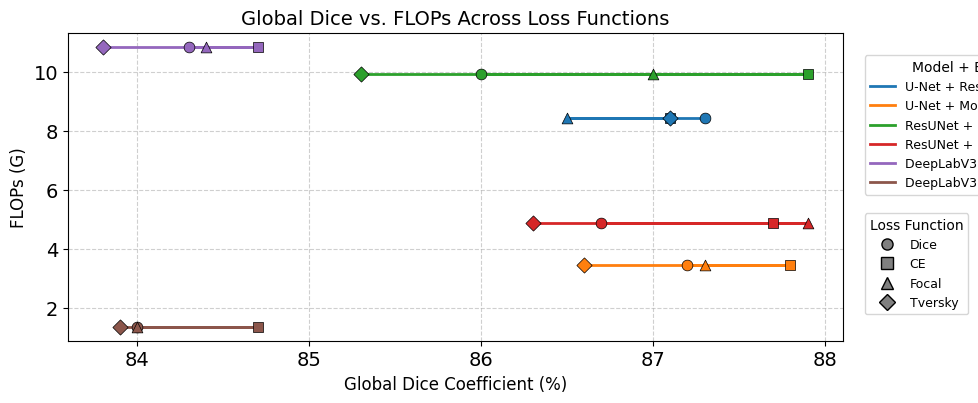

In [56]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

flops = {
    ('U-Net', 'ResNet34'): models_flops[0][0] / 1e9,
    ('U-Net', 'MobileNetV3'): models_flops[0][1] / 1e9,
    ('ResUNet', 'ResNet34'): models_flops[1][0] / 1e9,
    ('ResUNet', 'MobileNetV3'): models_flops[1][1] / 1e9,
    ('DeepLabV3+', 'ResNet34'): models_flops[2][0] / 1e9,
    ('DeepLabV3+', 'MobileNetV3'): models_flops[2][1] / 1e9,
}

dice_data = {
    ('U-Net', 'ResNet34'): [87.3, 87.1, 86.5, 87.1],
    ('U-Net', 'MobileNetV3'): [87.2, 87.8, 87.3, 86.6],
    ('ResUNet', 'ResNet34'): [86.0, 87.9, 87.0, 85.3],
    ('ResUNet', 'MobileNetV3'): [86.7, 87.7, 87.9, 86.3],
    ('DeepLabV3+', 'ResNet34'): [84.3, 84.7, 84.4, 83.8],
    ('DeepLabV3+', 'MobileNetV3'): [84.0, 84.7, 84.0, 83.9],
}

losses = ['Dice', 'CE', 'Focal', 'Tversky']
loss_markers = {'Dice': 'o', 'CE': 's', 'Focal': '^', 'Tversky': 'D'}

model_backbone_list = list(dice_data.keys())
colors = plt.cm.tab10.colors
color_map = {key: colors[i % 10] for i, key in enumerate(model_backbone_list)}

fig, ax = plt.subplots(figsize=(10, 4))

for (model, backbone), dice_list in dice_data.items():
    flops_val = flops[(model, backbone)]
    x_vals = dice_list
    y_vals = [flops_val] * len(dice_list)
    color = color_map[(model, backbone)]

    ax.plot(x_vals, y_vals, color=color, linewidth=2, zorder=2)
    for i, loss in enumerate(losses):
        ax.scatter(x_vals[i], y_vals[i],
                   marker=loss_markers[loss],
                   color=color,
                   s=60,
                   edgecolor='k',
                   linewidth=0.5,
                   zorder=3)

legend1_elements = [
    Line2D([0], [0], color=color_map[(m, b)], lw=2, label=f"{m} + {b}")
    for (m, b) in model_backbone_list
]
legend1 = ax.legend(handles=legend1_elements,
                    title="Model + Backbone",
                    loc='center left',
                    bbox_to_anchor=(1.02, 0.7),
                    fontsize=9,
                    title_fontsize=10,
                    frameon=True)

legend2_elements = [
    Line2D([0], [0], marker=loss_markers[loss], color='w',
           markerfacecolor='gray', markeredgecolor='k',
           markersize=8, linestyle='', label=loss)
    for loss in losses
]

legend2 = ax.legend(handles=legend2_elements,
                    title="Loss Function",
                    loc='center left',
                    bbox_to_anchor=(1.02, 0.25),
                    fontsize=9,
                    title_fontsize=10,
                    frameon=True)
ax.add_artist(legend1)

ax.set_xlabel('Global Dice Coefficient (%)', fontsize=12)
ax.set_ylabel('FLOPs (G)', fontsize=12)
ax.set_title('Global Dice vs. FLOPs Across Loss Functions', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

fig.savefig('dice_vs_flops_dual_legend.pdf',
            dpi=300,
            bbox_extra_artists=(legend1, legend2),
            bbox_inches='tight',
            pad_inches=0.5)

plt.show()